# Naive Bayes Classifier
## 1. Theoretical
The Naive Bayes classifier is a classifier which assumes that all features are conditionally independent - and is therefore called "naive".

First, we calculate the product of conditional probabilities:

$p(x_i \mid C_k) = p(C_k)\prod_{i=1}^{n} p(x_i\mid C_k)$

The classifier, based on the same logic:

$\hat{y} = \underset{k \in \left \{ 1, ..., K \right \} }{argmax}   p(C_k) \prod_{i=1}^{n} p(x_i\mid C_k)$

In [4]:
#Dependencies
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

## 2. A simple example

In [5]:
#data1
x_train = np.load('data1_xtrain.npy')
y_train = np.load('data1_ytrain.npy')
x_test = np.load('data1_xtest.npy')
y_test = np.load('data1_ytest.npy')

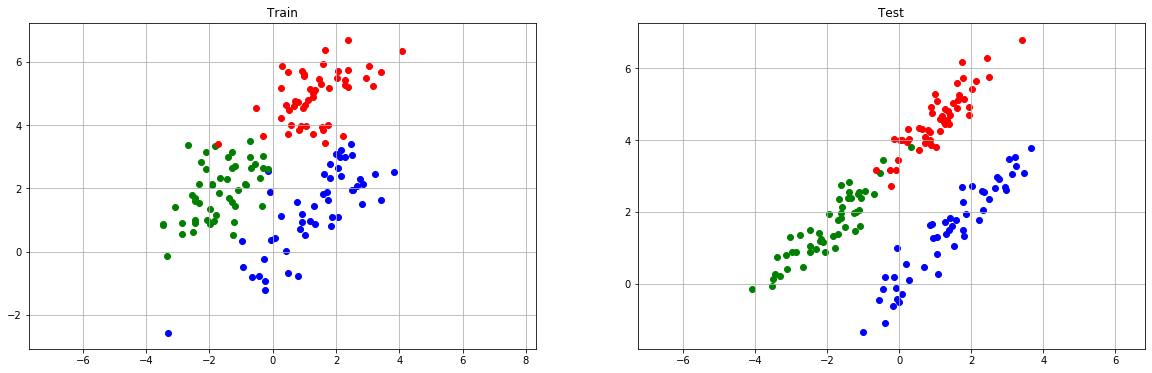

In [6]:
"""
b: blue
g: green
r: red
c: cyan
m: magenta
y: yellow
k: black
w: white
"""
colors = ['k', 'b', 'g', 'r', 'c', 'm', 'y', 'w']
plt.figure(figsize = (20,6))
plt.subplot(121)
plt.axis('equal')
plt.title('Train')
plt.grid()
for i in range(len(x_train)):
    c = colors[int(y_train[i])]
    plt.scatter(x_train[i,0], x_train[i,1], c = c)
plt.subplot(122)
plt.axis('equal')
plt.title('Test')
plt.grid()
for i in range(len(x_test)):
    c = colors[int(y_test[i])]
    plt.scatter(x_test[i,0], x_test[i,1], c = c)

In [7]:
#Inspiration from: https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/

#Separates data by class
def separate_by_class(xdata, ydata):
    separated = dict()
    for i in range(len(xdata)):
        vector = [xdata[i][0], xdata[i][1], ydata[i][0]]
        class_value = ydata[i][0]
        if (class_value not in separated):
            separated[class_value] = list()
        separated[class_value].append(vector)
    return separated
#Calcualtes the mean and variance
def summarize_dataset(dataset):
    summaries = [(np.mean(column), np.var(column), len(column)) for column in zip(*dataset)]
    del summaries[-1]
    return summaries
#Calculates the mean and variance by class
def summarize_by_class(xdata, ydata):
    separated = separate_by_class(xdata, ydata)
    summaries = dict()
    for class_value, rows in separated.items():
        summaries[class_value] = summarize_dataset(rows)
    return summaries
 
# Calculate the probabilities of predicting each class for a given row
def calculate_class_probabilities(summaries, row):
    total_rows = sum([summaries[label][0][2] for label in summaries])
    probabilities = dict()
    for class_value, class_summaries in summaries.items():
        probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
        for i in range(len(class_summaries)):
            mean, var, _ = class_summaries[i]
            probabilities[class_value] *= multivariate_normal.pdf(row[i], mean=mean, cov=var)
    return probabilities

Accuracy score:  0.9466666666666667


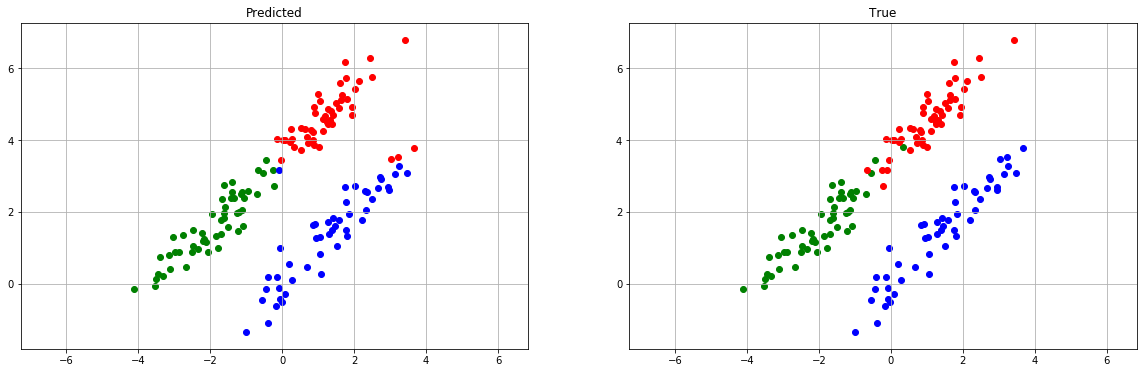

In [8]:
#Resulting values with our classifier
summaries = summarize_by_class(x_train, y_train)
predicted_values = np.zeros((len(y_test), 1))
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.axis('equal')
plt.grid()
plt.title('Predicted')
counter = 0
for row in x_test:
    probabilities = calculate_class_probabilities(summaries, row)
    predicted_value = max(probabilities.items(), key=operator.itemgetter(1))[0]
    c = colors[int(predicted_value)]
    plt.scatter(row[0], row[1], c = c)
    predicted_values[counter] = predicted_value
    counter += 1
    
plt.subplot(122)
plt.axis('equal')
plt.title('True')
plt.grid()
for i in range(len(x_test)):
    c = colors[int(y_test[i])]
    plt.scatter(x_test[i,0], x_test[i,1], c = c)
    
    
score = accuracy_score(y_test, predicted_values)
print('Accuracy score: ', score)

The classifier acheives an accuracy score of $94.7 \%$. As expected, there is a significant probability of misclassification in the area with overlapping classes (0,3). However, more interesting is the misclassification of blue points in the area around (4,4). We believe that the classifier weights the value of x2(y-axis) over a certain value (~3.5) to be of high significance $\rightarrow$ misclassifying blue points as red above this threshold.

## 3 Language recognizer
### 3.2.1 Training

In [9]:
#Load Data
en_trigrams = pd.read_csv('en_trigram_count.tsv', sep='\t', index_col=1, names=['Index', 'Trigram', 'Count'], header=None)
del en_trigrams['Index']
es_trigrams = pd.read_csv('es_trigram_count.tsv', sep='\t', index_col=1, names=['Index', 'Trigram', 'Count ES'], header=None)
del es_trigrams['Index']
fr_trigrams = pd.read_csv('fr_trigram_count.tsv', sep='\t', index_col=1, names=['Index', 'Trigram', 'Count FR'], header=None)
del fr_trigrams['Index']
pt_trigrams = pd.read_csv('pt_trigram_count.tsv', sep='\t', index_col=1, names=['Index', 'Trigram', 'Count PT'], header=None)
del pt_trigrams['Index']

#print('Shape en: ', np.shape(en_trigrams))
#print('Head en: ', en_trigrams.head(50))
#print('\nShape es: ', np.shape(es_trigrams))
#print('Head es: ', es_trigrams.head(50))
#print('\nShape fr: ', np.shape(fr_trigrams))
#print('Head fr: ', fr_trigrams.head(50))
#print('\nShape pt: ', np.shape(pt_trigrams))
#print('Head pt: ', pt_trigrams.head(50))

In [10]:
#Combining all dataframes to one
all_languages = en_trigrams
all_languages['Count2'] = es_trigrams['Count ES'].values
all_languages['Count3'] = fr_trigrams['Count FR'].values
all_languages['Count4'] = pt_trigrams['Count PT'].values

#X_train = dataframe with trigrams as columns
x_train = all_languages.transpose()
y_train = np.ravel([['en'], ['es'], ['fr'], ['pt']])

In [11]:
#Instantiate MultinomialNB object. Languages are given uniform prior likelihood
clf = MultinomialNB(fit_prior=False)

#Fit classifier to our data
clf.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

### 3.2.2 Testing

In [12]:
sentences = ['El cine esta abierto.',
            'Tu vais à escola hoje.',
            'Tu vais à escola hoje pois já estás melhor.',
            'English is easy to learn.',
            'Tu vas au cinéma demain matin.',
            'É fácil de entender.']
#Instantiate CountVectorizer. Analyzes trigrams of characters, vocabulary is the list of trigrams given previously
vocabulary = list(en_trigrams.index.values)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(3,3), vocabulary=vocabulary)

X_test = vectorizer.fit_transform(sentences)
y_test = [['es'],['pt'],['pt'],['en'],['fr'],['pt']]

In [16]:
#Predict using naive bayes classifier
predicted_lang = clf.predict(X_test)
proba = clf.predict_proba(X_test)

#Sort from low to high
#proba.sort()
clf_margins = []
for i in range(np.shape(proba)[0]):
    clf_margins.append(proba[i][3]-proba[i][2])
lang_score = accuracy_score(y_test, predicted_lang)

print(proba)
#print('clf_margins: ', clf_margins)
#print('score: ', lang_score)
print(predicted_lang)

[[2.95461304e-11 9.99777108e-01 1.15185486e-06 2.21740547e-04]
 [5.21413485e-21 2.68686074e-08 7.93050333e-01 2.06949640e-01]
 [3.54278995e-45 8.83826673e-17 2.91718699e-14 1.00000000e+00]
 [1.00000000e+00 1.21332297e-11 9.32047258e-13 6.09162609e-11]
 [6.20499678e-17 1.18839784e-08 9.99999116e-01 8.72358341e-07]
 [3.33741454e-15 5.48361253e-01 6.73702715e-06 4.51632010e-01]]
['es' 'fr' 'pt' 'en' 'fr' 'es']


### Comments

Text | Real Language | Recognized Language | Score | Classification Margin
--- | :---: | :---: | :---: | :---:
*El cine esta abierto.* | es | es | 1 | 0.9995
*Tu vais à escola hoje.* | pt | fr | 0 | 0.5861
*Tu vais à escola hoje pois já estás melhor.* | pt | pt | 1 | 0.9999
*English is easy to learn.* | en | en | 1 | 0.9999
*Tu vas au cinéma demain matin.* | fr | fr | 1 | 0.9999
*É fácil de entender.* | pt | es | 0 | 0.0967

#### Sentence 1
Sentence 1 is correctly predicted as Spanish. The closest contender is Portuguese, but the classifier still gives an answer with very high probability of being correct.
#### Sentence 2
Sentence 2 is incorrectly predicted as French. The probability of French is: 0.7930 and the probability for the correct answer, Portuguese: 0.2069. The decomposition of the sentence into trigrams result in, surprisingly, a better fit to the French language. 
#### Sentence 3
Sentence 3 is correctly predicted as Portuguese. The decomposition to trigrams of this sentence gave an overwhelming probability of it originating from the portuguese language.The second closest language was French, with a probability in the order of $10^{-14}$. However, sentence 2 and 3 have the same beginning, and sentence 2 was misclassified. 
#### Sentence 4
Sentence 4 is correctly predicted as English. Similar to the previous sentence, English is completly dominant with the second highest probability being in the order of $10^{-11}$.
#### Sentence 5
Sentence 5 is correctly predicted as French. Again, the classifier establishes an extremly high likelyhood of the sentence being French.
#### Sentence 6
Sentence 6 is incorrectly predicted as Spanish. The probabilities for Spanish and Portuguese are both significant, and the classification margin was the lowest of all test data. Spanish and Portuguese are very similar languages, at least when comparing sentence composition and letter frequency. Fun fact: Google Translate is able to translate the sentence to English perfectly from both Spanish and Portuguese.

Questions:
1. Interpretation of misclassification (Naive Bayes from Scratch)
2. Score Column in Table
3. Sentence 2